In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from src.data_loading import DlDataset
from src.utils import plot_performance
from src.convnet import do_train_trials, train_net, evaluate_net_classes, NumNet, ModelPerformanceSummary

import matplotlib.pyplot as plt

In [3]:
# Not very elegant but removes all the warnings about deprecated upsample funtion
import warnings
warnings.filterwarnings("ignore")

In [4]:
#import data for a 1000 pairs
N = 1000
dataset = DlDataset(N, normalize=True, upsample=None)
datasetShape = list(dataset.__shape__()[1:])

device = torch.device('cpu') #Hannes' gpu is not supported but has cuda cores... 

# Training for the boolean target

** Model architectures **
Number of trainable paramaters should be below 100'000
1. 2 conv layers, 2 batch norm layers, 2 linear layers
2. 2 conv layers, 2 batch norm layers, 2 linear layers, 1 dropout layer
3. 2 conv layers, 2 batch norm layers, 2 linear layers, 1 dropout layer, 1 maxpool layer
4. 3 conv layers, 3 batch norm layers, 2 linear layers
5. 3 conv layers, 3 batch norm layers, 2 linear layers, 1 dropout layer
6. 3 conv layers, 3 batch norm layers, 2 linear layers, 1 dropout layer, 1 maxpool layer

In [5]:
# The same net using NumNet class

models = []

# 2 convolutional layers followed by 2 linear layers with batch norm after each conv layer
config_2c_2l_2bn = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'BatchNormLayer'},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'BatchNormLayer'},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':2}]
models.append(NumNet(datasetShape, config_2c_2l_2bn, name='2conv_2lin_2bn'))

# 2 convolutional layers with batch norm and 1 dropout, followed by 2 linear layers 
config_2c_2l_2bn_1do = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'BatchNormLayer'},
          {'Type': 'DropoutLayer', 'p':0.5},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'BatchNormLayer'},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':2}]
models.append(NumNet(datasetShape, config_2c_2l_2bn_1do, name='2conv_2lin_2bn_1do'))

# 2 convolutional layers with batch norm and 1 maxpool and 1 dropout, followed by 2 linear layers 
config_2c_2l_2bn_1do_1mp = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'MaxPoolLayer', 'pooling':2, 'stride':2},
          {'Type': 'BatchNormLayer'},
          {'Type': 'DropoutLayer', 'p':0.5},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'BatchNormLayer'},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':2}]
models.append(NumNet(datasetShape, config_2c_2l_2bn_1do_1mp, name='2conv_2lin_2bn_1do_1mp'))

# 3 convolutional layers followed by 2 linear layers
"""
config_3c_2l = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
              {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
              {'Type': 'ConvLayer', 'out_channels':32, 'activation':'ReLU()', 'kernel_size':3},
              {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
              {'Type': 'LinearLayer', 'out_features':2}]
models.append(NumNet(datasetShape, config_3c_2l, name='3conv_2lin'))
"""
# 3 convolutional layers followed by 2 linear layers with batch norm after each conv layer
config_3c_2l_3bn = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
                    {'Type': 'BatchNormLayer'},
                    {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
                    {'Type': 'BatchNormLayer'},
                    {'Type': 'ConvLayer', 'out_channels':32, 'activation':'ReLU()', 'kernel_size':3},
                    {'Type': 'BatchNormLayer'},
                    {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
                    {'Type': 'LinearLayer', 'out_features':2}]
models.append(NumNet(datasetShape, config_3c_2l_3bn, name='3conv_2lin_3bn'))

# 3 convolutional layers followed by 2 linear layers with batch norm after each conv layer and 1 dropout
config_3c_2l_3bn_1do = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
                        {'Type': 'BatchNormLayer'},
                        {'Type': 'DropoutLayer', 'p':0.5},
                        {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
                        {'Type': 'BatchNormLayer'},
                        {'Type': 'ConvLayer', 'out_channels':32, 'activation':'ReLU()', 'kernel_size':3},
                        {'Type': 'BatchNormLayer'},
                        {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
                        {'Type': 'LinearLayer', 'out_features':2}]
models.append(NumNet(datasetShape, config_3c_2l_3bn_1do, name='3conv_2lin_3bn_1do'))

# 3 convolutional layers followed by 2 linear layers with batch norm after each conv layer and 1 dropout
config_3c_2l_3bn_1do_1mp = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
                            {'Type': 'MaxPoolLayer', 'pooling':2, 'stride':2},
                            {'Type': 'BatchNormLayer'},
                            {'Type': 'DropoutLayer', 'p':0.5},
                            {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
                            {'Type': 'BatchNormLayer'},
                            {'Type': 'ConvLayer', 'out_channels':32, 'activation':'ReLU()', 'kernel_size':3},
                            {'Type': 'BatchNormLayer'},
                            {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
                            {'Type': 'LinearLayer', 'out_features':2}]
models.append(NumNet(datasetShape, config_3c_2l_3bn_1do_1mp, name='3conv_2lin_3bn_1do_1mp'))

for model in models:
    model.summary()

 
Model '2conv_2lin_2bn'
Number              Layer               Input shape         Output shape        Trainable params    
0                   Conv2d              [2, 14, 14]         [8, 10, 10]         408
1                   BatchNorm2d         [8, 10, 10]         [8, 10, 10]         16
2                   Conv2d              [8, 10, 10]         [16, 8, 8]          1168
3                   BatchNorm2d         [16, 8, 8]          [16, 8, 8]          32
4                   Linear              1024                32                  32800
5                   Linear              32                  2                   66
----------------------------------------------------------------------------------------------------
Total number of trainable parameters: 34490
----------------------------------------------------------------------------------------------------
 
Model '2conv_2lin_2bn_1do'
Number              Layer               Input shape         Output shape        Trainable param

In [6]:
# Train parameter
epochs = 15
eta = 5e-2
lambda_l2 = 1e-3
gamma = 0.2
depth = 4
n_filters = 3
batch_spec = {'batch_size':100, 'shuffle':True, 'num_workers':4}

criterion = torch.nn.CrossEntropyLoss()

# Prepare dataloader£
dataloader = []
for mode in ['train','test']:
    if mode == 'train':
        dataset.train()
    elif mode == 'test':
        dataset.test()
    dataloader.append(dataset.return_dataloader(**batch_spec))


** Multiple training trials using the 'do_train_trials' function: **

In [7]:
trial_summaries = []
for model in models:
    print("-"*100)
    print("Running model: {}".format(model.name()))
    print("-"*100)
    optim_spec = {'type':'SGD', 'lr':eta, 'momentum':gamma}
    batch_spec = {'batch_size': 100, 'shuffle':True, 'num_workers':4}
    
    performance = do_train_trials(10, model, device, optim_spec, criterion, dataset, batch_spec,
                                    epochs=epochs, lambda_=1e-3, reg_type=None, 
                                    save=False)
    trial_summaries.append(performance)

----------------------------------------------------------------------------------------------------
Running model: 2conv_2lin_2bn
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Trial: 0
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.44s, Train Loss: 6.24e-03, Train Acc: 0.66, Val Loss: 5.00e-03, Val Acc: 0.78
Epoch 1: Duration: 0.42s, Train Loss: 4.40e-03, Train Acc: 0.80, Val Loss: 3.91e-03, Val Acc: 0.85
Epoch 2: Duration: 0.43s, Train Loss: 3.76e-03, Train Acc: 0.84, Val Loss: 3.55e-03, Val Acc: 0.85
Epoch 3: Duration: 0.41s, Train Loss: 3.31e-03, Train Acc: 0.87, Val Loss: 2.86e-03, Val Acc: 0.91
Epoch 4: Duration: 0.41s, Train Loss: 3.05e-03, Train Acc: 0.89, Val Loss: 2.65e-03, Val Acc: 0.91
Epoch 5: Duration: 0.45s, Train Loss: 2.61e-03, Train 

Epoch 10: Duration: 0.39s, Train Loss: 1.67e-03, Train Acc: 0.95, Val Loss: 1.43e-03, Val Acc: 0.97
Epoch 11: Duration: 0.40s, Train Loss: 1.49e-03, Train Acc: 0.97, Val Loss: 1.19e-03, Val Acc: 0.99
Epoch 12: Duration: 0.38s, Train Loss: 1.23e-03, Train Acc: 0.98, Val Loss: 9.77e-04, Val Acc: 1.00
Epoch 13: Duration: 0.38s, Train Loss: 1.05e-03, Train Acc: 0.99, Val Loss: 8.67e-04, Val Acc: 1.00
Epoch 14: Duration: 0.40s, Train Loss: 9.27e-04, Train Acc: 0.99, Val Loss: 7.75e-04, Val Acc: 0.99
----------------------------------------------------------------------------------------------------
Running Trial: 5
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.39s, Train Loss: 6.28e-03, Train Acc: 0.63, Val Loss: 5.59e-03, Val Acc: 0.73
Epoch 1: Duration: 0.40s, Train Loss: 5.13e-03, Train Acc: 0.75, Val Loss: 4.73e-03, Val Acc: 0.79
Epoch 2: Duration: 0.41s, Train Loss: 4.48e-03, Train Acc: 0.80, Val Loss: 4.09e-03

Epoch 7: Duration: 0.37s, Train Loss: 2.01e-03, Train Acc: 0.93, Val Loss: 1.59e-03, Val Acc: 0.97
Epoch 8: Duration: 0.38s, Train Loss: 1.69e-03, Train Acc: 0.95, Val Loss: 1.57e-03, Val Acc: 0.96
Epoch 9: Duration: 0.38s, Train Loss: 1.49e-03, Train Acc: 0.97, Val Loss: 1.36e-03, Val Acc: 0.96
Epoch 10: Duration: 0.38s, Train Loss: 1.36e-03, Train Acc: 0.97, Val Loss: 1.07e-03, Val Acc: 0.98
Epoch 11: Duration: 0.38s, Train Loss: 1.15e-03, Train Acc: 0.97, Val Loss: 1.00e-03, Val Acc: 0.98
Epoch 12: Duration: 0.39s, Train Loss: 9.67e-04, Train Acc: 0.99, Val Loss: 7.75e-04, Val Acc: 0.99
Epoch 13: Duration: 0.39s, Train Loss: 8.20e-04, Train Acc: 0.99, Val Loss: 6.77e-04, Val Acc: 0.99
Epoch 14: Duration: 0.38s, Train Loss: 7.02e-04, Train Acc: 1.00, Val Loss: 5.56e-04, Val Acc: 1.00
----------------------------------------------------------------------------------------------------
Out of 10 trials:
------------------------------------------------------------------------------------

Epoch 12: Duration: 0.41s, Train Loss: 4.24e-03, Train Acc: 0.81, Val Loss: 3.47e-03, Val Acc: 0.85
Epoch 13: Duration: 0.41s, Train Loss: 4.20e-03, Train Acc: 0.80, Val Loss: 3.39e-03, Val Acc: 0.85
Epoch 14: Duration: 0.38s, Train Loss: 4.23e-03, Train Acc: 0.81, Val Loss: 3.33e-03, Val Acc: 0.87
----------------------------------------------------------------------------------------------------
Running Trial: 4
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.46s, Train Loss: 6.97e-03, Train Acc: 0.58, Val Loss: 5.71e-03, Val Acc: 0.74
Epoch 1: Duration: 0.48s, Train Loss: 5.76e-03, Train Acc: 0.68, Val Loss: 4.91e-03, Val Acc: 0.77
Epoch 2: Duration: 0.44s, Train Loss: 5.15e-03, Train Acc: 0.74, Val Loss: 4.34e-03, Val Acc: 0.80
Epoch 3: Duration: 0.42s, Train Loss: 4.91e-03, Train Acc: 0.75, Val Loss: 4.04e-03, Val Acc: 0.81
Epoch 4: Duration: 0.45s, Train Loss: 4.75e-03, Train Acc: 0.76, Val Loss: 4.07e-03, 

Epoch 9: Duration: 0.45s, Train Loss: 4.06e-03, Train Acc: 0.82, Val Loss: 2.94e-03, Val Acc: 0.88
Epoch 10: Duration: 0.46s, Train Loss: 3.87e-03, Train Acc: 0.81, Val Loss: 2.82e-03, Val Acc: 0.89
Epoch 11: Duration: 0.42s, Train Loss: 3.73e-03, Train Acc: 0.85, Val Loss: 2.66e-03, Val Acc: 0.90
Epoch 12: Duration: 0.42s, Train Loss: 3.50e-03, Train Acc: 0.85, Val Loss: 2.73e-03, Val Acc: 0.89
Epoch 13: Duration: 0.37s, Train Loss: 3.24e-03, Train Acc: 0.86, Val Loss: 2.47e-03, Val Acc: 0.90
Epoch 14: Duration: 0.44s, Train Loss: 3.33e-03, Train Acc: 0.84, Val Loss: 2.40e-03, Val Acc: 0.91
----------------------------------------------------------------------------------------------------
Running Trial: 9
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.49s, Train Loss: 6.99e-03, Train Acc: 0.58, Val Loss: 5.98e-03, Val Acc: 0.71
Epoch 1: Duration: 0.50s, Train Loss: 5.88e-03, Train Acc: 0.67, Val Loss: 5.14e-03

Epoch 14: Duration: 0.59s, Train Loss: 4.60e-03, Train Acc: 0.78, Val Loss: 3.78e-03, Val Acc: 0.84
----------------------------------------------------------------------------------------------------
Running Trial: 3
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.65s, Train Loss: 7.03e-03, Train Acc: 0.56, Val Loss: 6.21e-03, Val Acc: 0.69
Epoch 1: Duration: 0.69s, Train Loss: 6.20e-03, Train Acc: 0.64, Val Loss: 5.72e-03, Val Acc: 0.74
Epoch 2: Duration: 0.45s, Train Loss: 5.81e-03, Train Acc: 0.69, Val Loss: 5.19e-03, Val Acc: 0.76
Epoch 3: Duration: 0.44s, Train Loss: 5.46e-03, Train Acc: 0.72, Val Loss: 4.79e-03, Val Acc: 0.79
Epoch 4: Duration: 0.45s, Train Loss: 5.39e-03, Train Acc: 0.73, Val Loss: 4.55e-03, Val Acc: 0.80
Epoch 5: Duration: 0.43s, Train Loss: 5.38e-03, Train Acc: 0.72, Val Loss: 4.51e-03, Val Acc: 0.81
Epoch 6: Duration: 0.51s, Train Loss: 4.99e-03, Train Acc: 0.76, Val Loss: 4.39e-03, Va

Epoch 11: Duration: 0.37s, Train Loss: 4.72e-03, Train Acc: 0.77, Val Loss: 4.04e-03, Val Acc: 0.82
Epoch 12: Duration: 0.37s, Train Loss: 4.58e-03, Train Acc: 0.77, Val Loss: 3.98e-03, Val Acc: 0.83
Epoch 13: Duration: 0.38s, Train Loss: 4.73e-03, Train Acc: 0.76, Val Loss: 3.82e-03, Val Acc: 0.84
Epoch 14: Duration: 0.41s, Train Loss: 4.46e-03, Train Acc: 0.80, Val Loss: 3.75e-03, Val Acc: 0.85
----------------------------------------------------------------------------------------------------
Running Trial: 8
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.35s, Train Loss: 8.05e-03, Train Acc: 0.54, Val Loss: 6.43e-03, Val Acc: 0.61
Epoch 1: Duration: 0.35s, Train Loss: 6.31e-03, Train Acc: 0.64, Val Loss: 6.05e-03, Val Acc: 0.64
Epoch 2: Duration: 0.35s, Train Loss: 6.01e-03, Train Acc: 0.68, Val Loss: 5.53e-03, Val Acc: 0.71
Epoch 3: Duration: 0.36s, Train Loss: 5.94e-03, Train Acc: 0.68, Val Loss: 5.47e-03,

Epoch 0: Duration: 0.47s, Train Loss: 6.25e-03, Train Acc: 0.63, Val Loss: 5.91e-03, Val Acc: 0.71
Epoch 1: Duration: 0.45s, Train Loss: 4.55e-03, Train Acc: 0.80, Val Loss: 4.61e-03, Val Acc: 0.83
Epoch 2: Duration: 0.43s, Train Loss: 3.77e-03, Train Acc: 0.85, Val Loss: 3.56e-03, Val Acc: 0.88
Epoch 3: Duration: 0.45s, Train Loss: 3.14e-03, Train Acc: 0.88, Val Loss: 2.93e-03, Val Acc: 0.90
Epoch 4: Duration: 0.48s, Train Loss: 2.68e-03, Train Acc: 0.91, Val Loss: 2.20e-03, Val Acc: 0.93
Epoch 5: Duration: 0.43s, Train Loss: 2.25e-03, Train Acc: 0.93, Val Loss: 1.85e-03, Val Acc: 0.95
Epoch 6: Duration: 0.46s, Train Loss: 1.92e-03, Train Acc: 0.94, Val Loss: 1.46e-03, Val Acc: 0.97
Epoch 7: Duration: 0.45s, Train Loss: 1.54e-03, Train Acc: 0.96, Val Loss: 1.29e-03, Val Acc: 0.98
Epoch 8: Duration: 0.44s, Train Loss: 1.32e-03, Train Acc: 0.98, Val Loss: 1.10e-03, Val Acc: 0.99
Epoch 9: Duration: 0.48s, Train Loss: 1.05e-03, Train Acc: 0.99, Val Loss: 9.11e-04, Val Acc: 0.99
Epoch 10: 

Epoch 14: Duration: 0.47s, Train Loss: 3.27e-04, Train Acc: 1.00, Val Loss: 2.89e-04, Val Acc: 1.00
----------------------------------------------------------------------------------------------------
Running Trial: 7
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.46s, Train Loss: 6.38e-03, Train Acc: 0.67, Val Loss: 6.17e-03, Val Acc: 0.58
Epoch 1: Duration: 0.47s, Train Loss: 4.06e-03, Train Acc: 0.81, Val Loss: 4.71e-03, Val Acc: 0.80
Epoch 2: Duration: 0.49s, Train Loss: 3.06e-03, Train Acc: 0.88, Val Loss: 3.44e-03, Val Acc: 0.89
Epoch 3: Duration: 0.46s, Train Loss: 2.46e-03, Train Acc: 0.92, Val Loss: 2.31e-03, Val Acc: 0.96
Epoch 4: Duration: 0.42s, Train Loss: 1.93e-03, Train Acc: 0.95, Val Loss: 1.73e-03, Val Acc: 0.97
Epoch 5: Duration: 0.43s, Train Loss: 1.56e-03, Train Acc: 0.97, Val Loss: 1.19e-03, Val Acc: 0.99
Epoch 6: Duration: 0.46s, Train Loss: 1.24e-03, Train Acc: 0.98, Val Loss: 9.54e-04, Va

Epoch 2: Duration: 0.47s, Train Loss: 5.38e-03, Train Acc: 0.72, Val Loss: 4.77e-03, Val Acc: 0.80
Epoch 3: Duration: 0.46s, Train Loss: 5.19e-03, Train Acc: 0.73, Val Loss: 4.50e-03, Val Acc: 0.82
Epoch 4: Duration: 0.45s, Train Loss: 4.83e-03, Train Acc: 0.77, Val Loss: 4.05e-03, Val Acc: 0.82
Epoch 5: Duration: 0.46s, Train Loss: 4.65e-03, Train Acc: 0.77, Val Loss: 3.94e-03, Val Acc: 0.82
Epoch 6: Duration: 0.47s, Train Loss: 4.61e-03, Train Acc: 0.78, Val Loss: 3.68e-03, Val Acc: 0.83
Epoch 7: Duration: 0.45s, Train Loss: 4.49e-03, Train Acc: 0.79, Val Loss: 3.54e-03, Val Acc: 0.85
Epoch 8: Duration: 0.45s, Train Loss: 4.29e-03, Train Acc: 0.81, Val Loss: 3.50e-03, Val Acc: 0.85
Epoch 9: Duration: 0.47s, Train Loss: 4.34e-03, Train Acc: 0.79, Val Loss: 3.44e-03, Val Acc: 0.84
Epoch 10: Duration: 0.44s, Train Loss: 4.16e-03, Train Acc: 0.81, Val Loss: 3.31e-03, Val Acc: 0.84
Epoch 11: Duration: 0.50s, Train Loss: 3.94e-03, Train Acc: 0.82, Val Loss: 3.04e-03, Val Acc: 0.87
Epoch 12

Epoch 0: Duration: 0.42s, Train Loss: 6.83e-03, Train Acc: 0.58, Val Loss: 6.19e-03, Val Acc: 0.71
Epoch 1: Duration: 0.44s, Train Loss: 6.09e-03, Train Acc: 0.65, Val Loss: 5.51e-03, Val Acc: 0.74
Epoch 2: Duration: 0.43s, Train Loss: 5.72e-03, Train Acc: 0.70, Val Loss: 4.91e-03, Val Acc: 0.77
Epoch 3: Duration: 0.44s, Train Loss: 5.42e-03, Train Acc: 0.71, Val Loss: 4.59e-03, Val Acc: 0.78
Epoch 4: Duration: 0.44s, Train Loss: 5.24e-03, Train Acc: 0.73, Val Loss: 4.41e-03, Val Acc: 0.79
Epoch 5: Duration: 0.45s, Train Loss: 4.96e-03, Train Acc: 0.74, Val Loss: 4.35e-03, Val Acc: 0.80
Epoch 6: Duration: 0.49s, Train Loss: 5.01e-03, Train Acc: 0.73, Val Loss: 3.96e-03, Val Acc: 0.83
Epoch 7: Duration: 0.47s, Train Loss: 4.55e-03, Train Acc: 0.79, Val Loss: 3.80e-03, Val Acc: 0.83
Epoch 8: Duration: 0.49s, Train Loss: 4.52e-03, Train Acc: 0.77, Val Loss: 3.75e-03, Val Acc: 0.84
Epoch 9: Duration: 0.45s, Train Loss: 4.47e-03, Train Acc: 0.78, Val Loss: 3.54e-03, Val Acc: 0.85
Epoch 10: 

Epoch 5: Duration: 0.36s, Train Loss: 5.38e-03, Train Acc: 0.72, Val Loss: 4.70e-03, Val Acc: 0.81
Epoch 6: Duration: 0.37s, Train Loss: 5.19e-03, Train Acc: 0.74, Val Loss: 4.47e-03, Val Acc: 0.82
Epoch 7: Duration: 0.40s, Train Loss: 5.10e-03, Train Acc: 0.75, Val Loss: 4.35e-03, Val Acc: 0.82
Epoch 8: Duration: 0.38s, Train Loss: 5.10e-03, Train Acc: 0.75, Val Loss: 4.21e-03, Val Acc: 0.83
Epoch 9: Duration: 0.37s, Train Loss: 4.93e-03, Train Acc: 0.77, Val Loss: 4.04e-03, Val Acc: 0.83
Epoch 10: Duration: 0.37s, Train Loss: 4.82e-03, Train Acc: 0.77, Val Loss: 3.93e-03, Val Acc: 0.83
Epoch 11: Duration: 0.42s, Train Loss: 4.66e-03, Train Acc: 0.76, Val Loss: 3.82e-03, Val Acc: 0.84
Epoch 12: Duration: 0.39s, Train Loss: 4.41e-03, Train Acc: 0.78, Val Loss: 3.72e-03, Val Acc: 0.85
Epoch 13: Duration: 0.36s, Train Loss: 4.55e-03, Train Acc: 0.77, Val Loss: 3.67e-03, Val Acc: 0.85
Epoch 14: Duration: 0.41s, Train Loss: 4.51e-03, Train Acc: 0.78, Val Loss: 3.49e-03, Val Acc: 0.86
-----

Epoch 2: Duration: 0.38s, Train Loss: 6.51e-03, Train Acc: 0.62, Val Loss: 6.05e-03, Val Acc: 0.70
Epoch 3: Duration: 0.38s, Train Loss: 6.07e-03, Train Acc: 0.67, Val Loss: 5.72e-03, Val Acc: 0.73
Epoch 4: Duration: 0.37s, Train Loss: 5.77e-03, Train Acc: 0.71, Val Loss: 5.18e-03, Val Acc: 0.77
Epoch 5: Duration: 0.38s, Train Loss: 5.48e-03, Train Acc: 0.72, Val Loss: 4.75e-03, Val Acc: 0.79
Epoch 6: Duration: 0.37s, Train Loss: 5.33e-03, Train Acc: 0.74, Val Loss: 4.62e-03, Val Acc: 0.80
Epoch 7: Duration: 0.37s, Train Loss: 5.13e-03, Train Acc: 0.72, Val Loss: 4.34e-03, Val Acc: 0.81
Epoch 8: Duration: 0.37s, Train Loss: 5.16e-03, Train Acc: 0.74, Val Loss: 4.28e-03, Val Acc: 0.81
Epoch 9: Duration: 0.39s, Train Loss: 4.87e-03, Train Acc: 0.77, Val Loss: 4.28e-03, Val Acc: 0.81
Epoch 10: Duration: 0.39s, Train Loss: 4.95e-03, Train Acc: 0.74, Val Loss: 4.07e-03, Val Acc: 0.82
Epoch 11: Duration: 0.39s, Train Loss: 4.62e-03, Train Acc: 0.78, Val Loss: 4.00e-03, Val Acc: 0.83
Epoch 12

Model: 2conv_2lin_2bn        avg_train_loss       min: 0.001 max: 0.006 std: 0.0003
Model: 2conv_2lin_2bn        avg_test_loss        min: 0.001 max: 0.005 std: 0.0003
Model: 2conv_2lin_2bn        avg_train_accuracy   min: 0.650 max: 0.989 std: 0.0143
Model: 2conv_2lin_2bn        avg_test_accuracy    min: 0.752 max: 0.991 std: 0.0128
Model: 2conv_2lin_2bn_1do    avg_train_loss       min: 0.004 max: 0.007 std: 0.0003
Model: 2conv_2lin_2bn_1do    avg_test_loss        min: 0.003 max: 0.006 std: 0.0004
Model: 2conv_2lin_2bn_1do    avg_train_accuracy   min: 0.571 max: 0.829 std: 0.0179
Model: 2conv_2lin_2bn_1do    avg_test_accuracy    min: 0.701 max: 0.889 std: 0.0227
Model: 2conv_2lin_2bn_1do_1mp  avg_train_loss       min: 0.005 max: 0.007 std: 0.0001
Model: 2conv_2lin_2bn_1do_1mp  avg_test_loss        min: 0.004 max: 0.006 std: 0.0002
Model: 2conv_2lin_2bn_1do_1mp  avg_train_accuracy   min: 0.558 max: 0.786 std: 0.0145
Model: 2conv_2lin_2bn_1do_1mp  avg_test_accuracy    min: 0.646 max: 0.

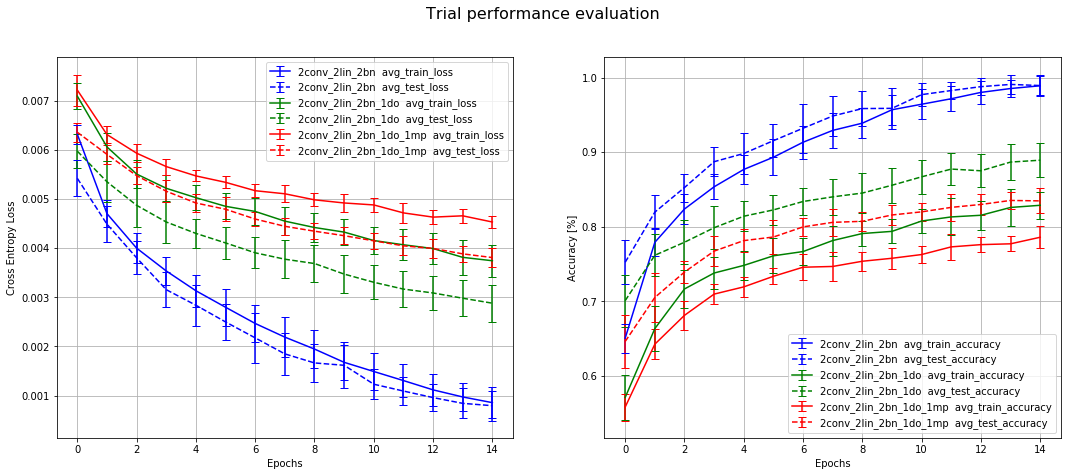

In [8]:
# Plot stuff for 2conv models
plot_this = [[('avg_train_loss','std_train_loss'),('avg_test_loss','std_test_loss')], \
             [('avg_train_accuracy','std_train_accuracy'),('avg_test_accuracy','std_test_accuracy')]]
axes, extrema = plot_performance(trial_summaries[0:3], plot_this, suptitle='Trial performance evaluation')
axes[0].set_ylabel('Cross Entropy Loss')
axes[1].set_ylabel('Accuracy [%]');

Model: 3conv_2lin_3bn        avg_train_loss       min: 0.000 max: 0.006 std: 0.0001
Model: 3conv_2lin_3bn        avg_test_loss        min: 0.000 max: 0.006 std: 0.0001
Model: 3conv_2lin_3bn        avg_train_accuracy   min: 0.646 max: 1.000 std: 0.0003
Model: 3conv_2lin_3bn        avg_test_accuracy    min: 0.693 max: 1.000 std: 0.0003
Model: 3conv_2lin_3bn_1do    avg_train_loss       min: 0.004 max: 0.007 std: 0.0003
Model: 3conv_2lin_3bn_1do    avg_test_loss        min: 0.003 max: 0.006 std: 0.0003
Model: 3conv_2lin_3bn_1do    avg_train_accuracy   min: 0.588 max: 0.831 std: 0.0220
Model: 3conv_2lin_3bn_1do    avg_test_accuracy    min: 0.694 max: 0.902 std: 0.0165
Model: 3conv_2lin_3bn_1do_1mp  avg_train_loss       min: 0.005 max: 0.007 std: 0.0001
Model: 3conv_2lin_3bn_1do_1mp  avg_test_loss        min: 0.004 max: 0.007 std: 0.0002
Model: 3conv_2lin_3bn_1do_1mp  avg_train_accuracy   min: 0.548 max: 0.785 std: 0.0099
Model: 3conv_2lin_3bn_1do_1mp  avg_test_accuracy    min: 0.596 max: 0.

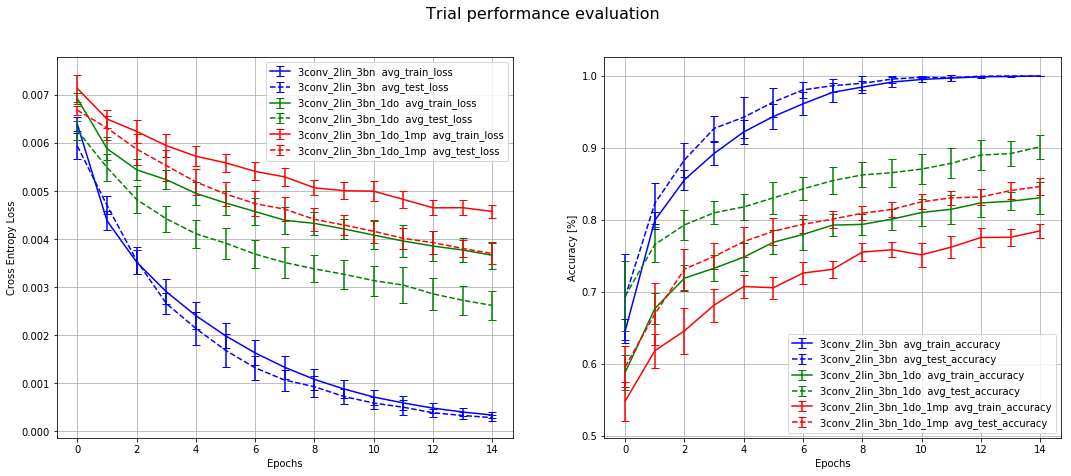

In [9]:
# Plot stuff for 3conv models
plot_this = [[('avg_train_loss','std_train_loss'),('avg_test_loss','std_test_loss')], \
             [('avg_train_accuracy','std_train_accuracy'),('avg_test_accuracy','std_test_accuracy')]]
axes, extrema = plot_performance(trial_summaries[3:], plot_this, suptitle='Trial performance evaluation')
axes[0].set_ylabel('Cross Entropy Loss')
axes[1].set_ylabel('Accuracy [%]');

# Training for the digit classes

In [10]:
# Train for digits and not the target.

dataset_digit = DlDataset(N, normalize=True, upsample=None, split_dataset = True)

datasetShape_digit = list(dataset_digit.__shape__()[1:])

** Model architectures **
Number of trainable paramaters should be below 100'000
1. 2 conv layers, 2 batch norm layers, 2 linear layers
2. 2 conv layers, 2 batch norm layers, 2 linear layers, 1 dropout layer
3. 2 conv layers, 2 batch norm layers, 2 linear layers, 1 dropout layer, 1 maxpool layer
4. 3 conv layers, 3 batch norm layers, 2 linear layers
5. 3 conv layers, 3 batch norm layers, 2 linear layers, 1 dropout layer
6. 3 conv layers, 3 batch norm layers, 2 linear layers, 1 dropout layer, 1 maxpool layer

In [11]:
# The same net using NumNet class but for digit classification

models_digit = []

# 2 convolutional layers followed by 2 linear layers with batch norm after each conv layer
config_2c_2l_2bn = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'BatchNormLayer'},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'BatchNormLayer'},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':10}]
models_digit.append(NumNet(datasetShape_digit, config_2c_2l_2bn, name='2conv_2lin_2bn'))

# 2 convolutional layers with batch norm and 1 dropout, followed by 2 linear layers 
config_2c_2l_2bn_1do = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'BatchNormLayer'},
          {'Type': 'DropoutLayer', 'p':0.5},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'BatchNormLayer'},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':10}]
models_digit.append(NumNet(datasetShape_digit, config_2c_2l_2bn_1do, name='2conv_2lin_2bn_1do'))

# 2 convolutional layers with batch norm and 1 maxpool and 1 dropout, followed by 2 linear layers 
config_2c_2l_2bn_1do_1mp = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'MaxPoolLayer', 'pooling':2, 'stride':2},
          {'Type': 'BatchNormLayer'},
          {'Type': 'DropoutLayer', 'p':0.5},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'BatchNormLayer'},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':10}]
models_digit.append(NumNet(datasetShape_digit, config_2c_2l_2bn_1do_1mp, name='2conv_2lin_2bn_1do_1mp'))

# 3 convolutional layers followed by 2 linear layers with batch norm after each conv layer
config_3c_2l_3bn = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
                    {'Type': 'BatchNormLayer'},
                    {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
                    {'Type': 'BatchNormLayer'},
                    {'Type': 'ConvLayer', 'out_channels':32, 'activation':'ReLU()', 'kernel_size':3},
                    {'Type': 'BatchNormLayer'},
                    {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
                    {'Type': 'LinearLayer', 'out_features':10}]
models_digit.append(NumNet(datasetShape_digit, config_3c_2l_3bn, name='3conv_2lin_3bn'))

# 3 convolutional layers followed by 2 linear layers with batch norm after each conv layer and 1 dropout
config_3c_2l_3bn_1do = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
                        {'Type': 'BatchNormLayer'},
                        {'Type': 'DropoutLayer', 'p':0.5},
                        {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
                        {'Type': 'BatchNormLayer'},
                        {'Type': 'ConvLayer', 'out_channels':32, 'activation':'ReLU()', 'kernel_size':3},
                        {'Type': 'BatchNormLayer'},
                        {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
                        {'Type': 'LinearLayer', 'out_features':10}]
models_digit.append(NumNet(datasetShape_digit, config_3c_2l_3bn_1do, name='3conv_2lin_3bn_1do'))

# 3 convolutional layers followed by 2 linear layers with batch norm after each conv layer and 1 dropout
config_3c_2l_3bn_1do_1mp = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
                            {'Type': 'MaxPoolLayer', 'pooling':2, 'stride':2},
                            {'Type': 'BatchNormLayer'},
                            {'Type': 'DropoutLayer', 'p':0.5},
                            {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
                            {'Type': 'BatchNormLayer'},
                            {'Type': 'ConvLayer', 'out_channels':32, 'activation':'ReLU()', 'kernel_size':3},
                            {'Type': 'BatchNormLayer'},
                            {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
                            {'Type': 'LinearLayer', 'out_features':10}]
models_digit.append(NumNet(datasetShape_digit, config_3c_2l_3bn_1do_1mp, name='3conv_2lin_3bn_1do_1mp'))

for model in models_digit:
    model.summary()

 
Model '2conv_2lin_2bn'
Number              Layer               Input shape         Output shape        Trainable params    
0                   Conv2d              [1, 14, 14]         [8, 10, 10]         208
1                   BatchNorm2d         [8, 10, 10]         [8, 10, 10]         16
2                   Conv2d              [8, 10, 10]         [16, 8, 8]          1168
3                   BatchNorm2d         [16, 8, 8]          [16, 8, 8]          32
4                   Linear              1024                32                  32800
5                   Linear              32                  10                  330
----------------------------------------------------------------------------------------------------
Total number of trainable parameters: 34554
----------------------------------------------------------------------------------------------------
 
Model '2conv_2lin_2bn_1do'
Number              Layer               Input shape         Output shape        Trainable para

In [12]:
# Train parameter
epochs = 15
mini_batch_size = 100
eta = 5e-2
lambda_l2 = 1e-3
gamma = 0.2
depth = 4
n_filters = 3

batch_spec = {'batch_size':100, 'shuffle':True, 'num_workers':4}

criterion = torch.nn.CrossEntropyLoss()

# Prepare dataloader
dataloader = []
for mode in ['train','test']:
    if mode == 'train':
        dataset_digit.train()
    elif mode == 'test':
        dataset_digit.test()
    dataloader.append(dataset_digit.return_dataloader(**batch_spec))


** Multiple training trials using the 'do_train_trials' function: **

In [13]:
trial_summaries_digit = []
for model in models_digit:
    print("-"*100)
    print("Running model: {}".format(model.name()))
    print("-"*100)
    optim_spec = {'type':'SGD', 'lr':eta, 'momentum':gamma}
    batch_spec = {'batch_size': 100, 'shuffle':True, 'num_workers':4}
    
    performance = do_train_trials(10, model, device, optim_spec, criterion, dataset_digit, batch_spec,
                                    epochs=epochs, lambda_=1e-3, reg_type=None, 
                                    save=False)
    trial_summaries_digit.append(performance)

----------------------------------------------------------------------------------------------------
Running model: 2conv_2lin_2bn
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Trial: 0
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.44s, Train Loss: 1.87e-02, Train Acc: 0.38, Val Loss: 1.55e-02, Val Acc: 0.66
Epoch 1: Duration: 0.43s, Train Loss: 9.89e-03, Train Acc: 0.73, Val Loss: 8.15e-03, Val Acc: 0.82
Epoch 2: Duration: 0.45s, Train Loss: 5.77e-03, Train Acc: 0.85, Val Loss: 4.61e-03, Val Acc: 0.92
Epoch 3: Duration: 0.45s, Train Loss: 4.00e-03, Train Acc: 0.91, Val Loss: 3.23e-03, Val Acc: 0.93
Epoch 4: Duration: 0.46s, Train Loss: 3.02e-03, Train Acc: 0.93, Val Loss: 2.42e-03, Val Acc: 0.95
Epoch 5: Duration: 0.44s, Train Loss: 2.37e-03, Train 

Epoch 10: Duration: 0.44s, Train Loss: 1.48e-03, Train Acc: 0.97, Val Loss: 1.26e-03, Val Acc: 0.98
Epoch 11: Duration: 0.44s, Train Loss: 1.25e-03, Train Acc: 0.97, Val Loss: 1.07e-03, Val Acc: 0.98
Epoch 12: Duration: 0.45s, Train Loss: 1.07e-03, Train Acc: 0.98, Val Loss: 8.72e-04, Val Acc: 0.99
Epoch 13: Duration: 0.45s, Train Loss: 9.22e-04, Train Acc: 0.99, Val Loss: 7.83e-04, Val Acc: 1.00
Epoch 14: Duration: 0.40s, Train Loss: 8.22e-04, Train Acc: 0.99, Val Loss: 7.63e-04, Val Acc: 1.00
----------------------------------------------------------------------------------------------------
Running Trial: 5
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.42s, Train Loss: 1.61e-02, Train Acc: 0.48, Val Loss: 1.18e-02, Val Acc: 0.74
Epoch 1: Duration: 0.43s, Train Loss: 7.58e-03, Train Acc: 0.79, Val Loss: 6.44e-03, Val Acc: 0.84
Epoch 2: Duration: 0.44s, Train Loss: 5.05e-03, Train Acc: 0.87, Val Loss: 4.18e-03

Epoch 7: Duration: 0.45s, Train Loss: 1.79e-03, Train Acc: 0.96, Val Loss: 1.47e-03, Val Acc: 0.97
Epoch 8: Duration: 0.51s, Train Loss: 1.54e-03, Train Acc: 0.97, Val Loss: 1.37e-03, Val Acc: 0.98
Epoch 9: Duration: 0.43s, Train Loss: 1.31e-03, Train Acc: 0.98, Val Loss: 1.07e-03, Val Acc: 0.98
Epoch 10: Duration: 0.45s, Train Loss: 1.14e-03, Train Acc: 0.98, Val Loss: 9.58e-04, Val Acc: 0.99
Epoch 11: Duration: 0.45s, Train Loss: 9.94e-04, Train Acc: 0.98, Val Loss: 8.32e-04, Val Acc: 0.99
Epoch 12: Duration: 0.44s, Train Loss: 8.73e-04, Train Acc: 0.99, Val Loss: 7.88e-04, Val Acc: 0.99
Epoch 13: Duration: 0.49s, Train Loss: 7.65e-04, Train Acc: 0.99, Val Loss: 6.53e-04, Val Acc: 0.99
Epoch 14: Duration: 0.51s, Train Loss: 6.81e-04, Train Acc: 0.99, Val Loss: 5.84e-04, Val Acc: 1.00
----------------------------------------------------------------------------------------------------
Out of 10 trials:
------------------------------------------------------------------------------------

Epoch 12: Duration: 0.47s, Train Loss: 3.74e-03, Train Acc: 0.89, Val Loss: 1.97e-03, Val Acc: 0.95
Epoch 13: Duration: 0.44s, Train Loss: 3.45e-03, Train Acc: 0.91, Val Loss: 1.91e-03, Val Acc: 0.94
Epoch 14: Duration: 0.42s, Train Loss: 3.15e-03, Train Acc: 0.91, Val Loss: 1.77e-03, Val Acc: 0.95
----------------------------------------------------------------------------------------------------
Running Trial: 4
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.43s, Train Loss: 1.90e-02, Train Acc: 0.37, Val Loss: 1.20e-02, Val Acc: 0.70
Epoch 1: Duration: 0.41s, Train Loss: 1.08e-02, Train Acc: 0.71, Val Loss: 6.33e-03, Val Acc: 0.86
Epoch 2: Duration: 0.42s, Train Loss: 7.49e-03, Train Acc: 0.80, Val Loss: 4.12e-03, Val Acc: 0.89
Epoch 3: Duration: 0.44s, Train Loss: 6.11e-03, Train Acc: 0.83, Val Loss: 3.34e-03, Val Acc: 0.91
Epoch 4: Duration: 0.41s, Train Loss: 4.80e-03, Train Acc: 0.87, Val Loss: 2.69e-03, 

Epoch 9: Duration: 0.50s, Train Loss: 3.55e-03, Train Acc: 0.89, Val Loss: 1.98e-03, Val Acc: 0.95
Epoch 10: Duration: 0.67s, Train Loss: 3.16e-03, Train Acc: 0.91, Val Loss: 1.75e-03, Val Acc: 0.96
Epoch 11: Duration: 0.47s, Train Loss: 3.03e-03, Train Acc: 0.91, Val Loss: 1.58e-03, Val Acc: 0.96
Epoch 12: Duration: 0.45s, Train Loss: 2.99e-03, Train Acc: 0.91, Val Loss: 1.51e-03, Val Acc: 0.96
Epoch 13: Duration: 0.49s, Train Loss: 2.49e-03, Train Acc: 0.93, Val Loss: 1.37e-03, Val Acc: 0.97
Epoch 14: Duration: 0.47s, Train Loss: 2.34e-03, Train Acc: 0.94, Val Loss: 1.29e-03, Val Acc: 0.97
----------------------------------------------------------------------------------------------------
Running Trial: 9
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.48s, Train Loss: 2.02e-02, Train Acc: 0.32, Val Loss: 1.40e-02, Val Acc: 0.64
Epoch 1: Duration: 0.56s, Train Loss: 1.29e-02, Train Acc: 0.59, Val Loss: 8.57e-03

Epoch 14: Duration: 0.40s, Train Loss: 5.20e-03, Train Acc: 0.84, Val Loss: 3.23e-03, Val Acc: 0.92
----------------------------------------------------------------------------------------------------
Running Trial: 3
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.41s, Train Loss: 2.34e-02, Train Acc: 0.13, Val Loss: 1.95e-02, Val Acc: 0.41
Epoch 1: Duration: 0.43s, Train Loss: 1.88e-02, Train Acc: 0.36, Val Loss: 1.56e-02, Val Acc: 0.67
Epoch 2: Duration: 0.41s, Train Loss: 1.58e-02, Train Acc: 0.52, Val Loss: 1.25e-02, Val Acc: 0.74
Epoch 3: Duration: 0.40s, Train Loss: 1.38e-02, Train Acc: 0.59, Val Loss: 1.04e-02, Val Acc: 0.77
Epoch 4: Duration: 0.38s, Train Loss: 1.23e-02, Train Acc: 0.62, Val Loss: 8.66e-03, Val Acc: 0.81
Epoch 5: Duration: 0.43s, Train Loss: 1.06e-02, Train Acc: 0.69, Val Loss: 7.42e-03, Val Acc: 0.84
Epoch 6: Duration: 0.41s, Train Loss: 9.56e-03, Train Acc: 0.73, Val Loss: 6.37e-03, Va

Epoch 11: Duration: 0.51s, Train Loss: 4.99e-03, Train Acc: 0.86, Val Loss: 2.88e-03, Val Acc: 0.93
Epoch 12: Duration: 0.41s, Train Loss: 4.75e-03, Train Acc: 0.87, Val Loss: 2.68e-03, Val Acc: 0.93
Epoch 13: Duration: 0.43s, Train Loss: 4.72e-03, Train Acc: 0.86, Val Loss: 2.47e-03, Val Acc: 0.94
Epoch 14: Duration: 0.38s, Train Loss: 4.40e-03, Train Acc: 0.87, Val Loss: 2.29e-03, Val Acc: 0.94
----------------------------------------------------------------------------------------------------
Running Trial: 8
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.42s, Train Loss: 2.25e-02, Train Acc: 0.22, Val Loss: 1.91e-02, Val Acc: 0.33
Epoch 1: Duration: 0.40s, Train Loss: 1.80e-02, Train Acc: 0.39, Val Loss: 1.43e-02, Val Acc: 0.58
Epoch 2: Duration: 0.40s, Train Loss: 1.47e-02, Train Acc: 0.55, Val Loss: 1.12e-02, Val Acc: 0.68
Epoch 3: Duration: 0.40s, Train Loss: 1.26e-02, Train Acc: 0.64, Val Loss: 9.20e-03,

Epoch 0: Duration: 0.63s, Train Loss: 1.60e-02, Train Acc: 0.48, Val Loss: 1.42e-02, Val Acc: 0.72
Epoch 1: Duration: 0.60s, Train Loss: 7.29e-03, Train Acc: 0.82, Val Loss: 7.04e-03, Val Acc: 0.87
Epoch 2: Duration: 0.57s, Train Loss: 4.59e-03, Train Acc: 0.88, Val Loss: 4.30e-03, Val Acc: 0.91
Epoch 3: Duration: 0.57s, Train Loss: 3.43e-03, Train Acc: 0.91, Val Loss: 2.83e-03, Val Acc: 0.95
Epoch 4: Duration: 0.60s, Train Loss: 2.66e-03, Train Acc: 0.94, Val Loss: 2.10e-03, Val Acc: 0.96
Epoch 5: Duration: 0.54s, Train Loss: 2.11e-03, Train Acc: 0.95, Val Loss: 1.72e-03, Val Acc: 0.97
Epoch 6: Duration: 0.52s, Train Loss: 1.71e-03, Train Acc: 0.97, Val Loss: 1.38e-03, Val Acc: 0.98
Epoch 7: Duration: 0.59s, Train Loss: 1.40e-03, Train Acc: 0.98, Val Loss: 1.19e-03, Val Acc: 0.99
Epoch 8: Duration: 0.53s, Train Loss: 1.16e-03, Train Acc: 0.98, Val Loss: 9.79e-04, Val Acc: 0.99
Epoch 9: Duration: 0.53s, Train Loss: 9.98e-04, Train Acc: 0.99, Val Loss: 8.12e-04, Val Acc: 0.99
Epoch 10: 

Epoch 14: Duration: 0.54s, Train Loss: 4.06e-04, Train Acc: 1.00, Val Loss: 3.56e-04, Val Acc: 1.00
----------------------------------------------------------------------------------------------------
Running Trial: 7
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.60s, Train Loss: 1.74e-02, Train Acc: 0.44, Val Loss: 1.69e-02, Val Acc: 0.68
Epoch 1: Duration: 0.61s, Train Loss: 7.83e-03, Train Acc: 0.79, Val Loss: 8.77e-03, Val Acc: 0.87
Epoch 2: Duration: 0.56s, Train Loss: 4.96e-03, Train Acc: 0.88, Val Loss: 4.66e-03, Val Acc: 0.92
Epoch 3: Duration: 0.58s, Train Loss: 3.61e-03, Train Acc: 0.92, Val Loss: 2.96e-03, Val Acc: 0.95
Epoch 4: Duration: 0.59s, Train Loss: 2.59e-03, Train Acc: 0.95, Val Loss: 2.11e-03, Val Acc: 0.97
Epoch 5: Duration: 0.55s, Train Loss: 2.07e-03, Train Acc: 0.97, Val Loss: 1.64e-03, Val Acc: 0.97
Epoch 6: Duration: 0.54s, Train Loss: 1.63e-03, Train Acc: 0.98, Val Loss: 1.29e-03, Va

Epoch 2: Duration: 0.56s, Train Loss: 1.04e-02, Train Acc: 0.72, Val Loss: 7.29e-03, Val Acc: 0.83
Epoch 3: Duration: 0.59s, Train Loss: 8.26e-03, Train Acc: 0.78, Val Loss: 5.36e-03, Val Acc: 0.86
Epoch 4: Duration: 0.54s, Train Loss: 6.92e-03, Train Acc: 0.80, Val Loss: 4.21e-03, Val Acc: 0.88
Epoch 5: Duration: 0.58s, Train Loss: 6.28e-03, Train Acc: 0.83, Val Loss: 3.62e-03, Val Acc: 0.90
Epoch 6: Duration: 0.59s, Train Loss: 5.12e-03, Train Acc: 0.86, Val Loss: 3.04e-03, Val Acc: 0.91
Epoch 7: Duration: 0.56s, Train Loss: 4.49e-03, Train Acc: 0.86, Val Loss: 2.53e-03, Val Acc: 0.93
Epoch 8: Duration: 0.61s, Train Loss: 4.17e-03, Train Acc: 0.87, Val Loss: 2.27e-03, Val Acc: 0.93
Epoch 9: Duration: 0.71s, Train Loss: 3.79e-03, Train Acc: 0.89, Val Loss: 1.93e-03, Val Acc: 0.95
Epoch 10: Duration: 0.84s, Train Loss: 3.40e-03, Train Acc: 0.91, Val Loss: 1.70e-03, Val Acc: 0.95
Epoch 11: Duration: 0.67s, Train Loss: 3.13e-03, Train Acc: 0.91, Val Loss: 1.56e-03, Val Acc: 0.96
Epoch 12

Epoch 0: Duration: 0.61s, Train Loss: 2.05e-02, Train Acc: 0.29, Val Loss: 1.69e-02, Val Acc: 0.64
Epoch 1: Duration: 0.57s, Train Loss: 1.37e-02, Train Acc: 0.61, Val Loss: 9.94e-03, Val Acc: 0.80
Epoch 2: Duration: 0.55s, Train Loss: 9.72e-03, Train Acc: 0.73, Val Loss: 6.44e-03, Val Acc: 0.83
Epoch 3: Duration: 0.55s, Train Loss: 7.19e-03, Train Acc: 0.80, Val Loss: 4.60e-03, Val Acc: 0.88
Epoch 4: Duration: 0.60s, Train Loss: 6.09e-03, Train Acc: 0.83, Val Loss: 3.60e-03, Val Acc: 0.89
Epoch 5: Duration: 0.61s, Train Loss: 5.42e-03, Train Acc: 0.85, Val Loss: 3.07e-03, Val Acc: 0.91
Epoch 6: Duration: 0.58s, Train Loss: 4.65e-03, Train Acc: 0.87, Val Loss: 2.64e-03, Val Acc: 0.92
Epoch 7: Duration: 0.58s, Train Loss: 4.26e-03, Train Acc: 0.88, Val Loss: 2.27e-03, Val Acc: 0.93
Epoch 8: Duration: 0.58s, Train Loss: 3.91e-03, Train Acc: 0.88, Val Loss: 2.04e-03, Val Acc: 0.94
Epoch 9: Duration: 0.56s, Train Loss: 3.37e-03, Train Acc: 0.90, Val Loss: 1.85e-03, Val Acc: 0.95
Epoch 10: 

Epoch 5: Duration: 0.44s, Train Loss: 1.62e-02, Train Acc: 0.48, Val Loss: 1.40e-02, Val Acc: 0.63
Epoch 6: Duration: 0.48s, Train Loss: 1.48e-02, Train Acc: 0.57, Val Loss: 1.24e-02, Val Acc: 0.70
Epoch 7: Duration: 0.49s, Train Loss: 1.36e-02, Train Acc: 0.60, Val Loss: 1.12e-02, Val Acc: 0.73
Epoch 8: Duration: 0.44s, Train Loss: 1.23e-02, Train Acc: 0.66, Val Loss: 9.89e-03, Val Acc: 0.75
Epoch 9: Duration: 0.51s, Train Loss: 1.13e-02, Train Acc: 0.68, Val Loss: 8.61e-03, Val Acc: 0.80
Epoch 10: Duration: 0.67s, Train Loss: 1.02e-02, Train Acc: 0.72, Val Loss: 7.59e-03, Val Acc: 0.82
Epoch 11: Duration: 0.55s, Train Loss: 9.35e-03, Train Acc: 0.76, Val Loss: 6.93e-03, Val Acc: 0.83
Epoch 12: Duration: 0.49s, Train Loss: 8.64e-03, Train Acc: 0.78, Val Loss: 6.13e-03, Val Acc: 0.86
Epoch 13: Duration: 0.45s, Train Loss: 8.22e-03, Train Acc: 0.77, Val Loss: 5.52e-03, Val Acc: 0.88
Epoch 14: Duration: 0.44s, Train Loss: 7.60e-03, Train Acc: 0.79, Val Loss: 5.05e-03, Val Acc: 0.89
-----

Epoch 2: Duration: 0.45s, Train Loss: 1.56e-02, Train Acc: 0.56, Val Loss: 1.27e-02, Val Acc: 0.75
Epoch 3: Duration: 0.46s, Train Loss: 1.39e-02, Train Acc: 0.61, Val Loss: 1.05e-02, Val Acc: 0.79
Epoch 4: Duration: 0.42s, Train Loss: 1.22e-02, Train Acc: 0.68, Val Loss: 8.75e-03, Val Acc: 0.81
Epoch 5: Duration: 0.44s, Train Loss: 1.06e-02, Train Acc: 0.73, Val Loss: 7.55e-03, Val Acc: 0.83
Epoch 6: Duration: 0.42s, Train Loss: 9.78e-03, Train Acc: 0.74, Val Loss: 6.69e-03, Val Acc: 0.85
Epoch 7: Duration: 0.39s, Train Loss: 8.74e-03, Train Acc: 0.77, Val Loss: 5.64e-03, Val Acc: 0.87
Epoch 8: Duration: 0.42s, Train Loss: 8.03e-03, Train Acc: 0.79, Val Loss: 5.03e-03, Val Acc: 0.89
Epoch 9: Duration: 0.41s, Train Loss: 7.69e-03, Train Acc: 0.78, Val Loss: 4.32e-03, Val Acc: 0.91
Epoch 10: Duration: 0.39s, Train Loss: 6.64e-03, Train Acc: 0.82, Val Loss: 4.01e-03, Val Acc: 0.91
Epoch 11: Duration: 0.40s, Train Loss: 5.89e-03, Train Acc: 0.85, Val Loss: 3.65e-03, Val Acc: 0.91
Epoch 12

Model: 2conv_2lin_2bn        avg_train_loss       min: 0.001 max: 0.018 std: 0.0001
Model: 2conv_2lin_2bn        avg_test_loss        min: 0.001 max: 0.014 std: 0.0001
Model: 2conv_2lin_2bn        avg_train_target_accuracy min: 0.805 max: 0.968 std: 0.0077
Model: 2conv_2lin_2bn        avg_test_target_accuracy min: 0.792 max: 0.968 std: 0.0077
Model: 2conv_2lin_2bn_1do    avg_train_loss       min: 0.003 max: 0.020 std: 0.0004
Model: 2conv_2lin_2bn_1do    avg_test_loss        min: 0.001 max: 0.015 std: 0.0002
Model: 2conv_2lin_2bn_1do    avg_train_target_accuracy min: 0.722 max: 0.933 std: 0.0070
Model: 2conv_2lin_2bn_1do    avg_test_target_accuracy min: 0.778 max: 0.953 std: 0.0064
Model: 2conv_2lin_2bn_1do_1mp  avg_train_loss       min: 0.005 max: 0.023 std: 0.0006
Model: 2conv_2lin_2bn_1do_1mp  avg_test_loss        min: 0.003 max: 0.019 std: 0.0005
Model: 2conv_2lin_2bn_1do_1mp  avg_train_target_accuracy min: 0.614 max: 0.892 std: 0.0119
Model: 2conv_2lin_2bn_1do_1mp  avg_test_target_

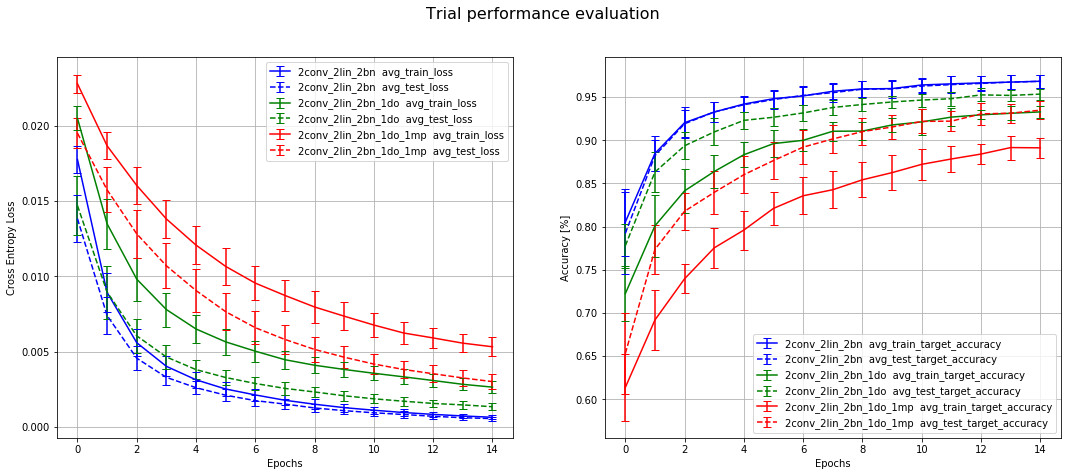

In [14]:
# Plot stuff for 2conv models
plot_this = [[('avg_train_loss','std_train_loss'),('avg_test_loss','std_test_loss')], \
             [('avg_train_target_accuracy','std_train_target_accuracy'),('avg_test_target_accuracy','std_test_target_accuracy')]]
axes, extrema = plot_performance(trial_summaries_digit[0:3], plot_this, suptitle='Trial performance evaluation')
axes[0].set_ylabel('Cross Entropy Loss')
axes[1].set_ylabel('Accuracy [%]');

Model: 3conv_2lin_3bn        avg_train_loss       min: 0.000 max: 0.017 std: 0.0001
Model: 3conv_2lin_3bn        avg_test_loss        min: 0.000 max: 0.016 std: 0.0000
Model: 3conv_2lin_3bn        avg_train_target_accuracy min: 0.839 max: 0.974 std: 0.0036
Model: 3conv_2lin_3bn        avg_test_target_accuracy min: 0.821 max: 0.973 std: 0.0040
Model: 3conv_2lin_3bn_1do    avg_train_loss       min: 0.003 max: 0.021 std: 0.0003
Model: 3conv_2lin_3bn_1do    avg_test_loss        min: 0.001 max: 0.018 std: 0.0002
Model: 3conv_2lin_3bn_1do    avg_train_target_accuracy min: 0.702 max: 0.935 std: 0.0110
Model: 3conv_2lin_3bn_1do    avg_test_target_accuracy min: 0.763 max: 0.955 std: 0.0104
Model: 3conv_2lin_3bn_1do_1mp  avg_train_loss       min: 0.006 max: 0.023 std: 0.0009
Model: 3conv_2lin_3bn_1do_1mp  avg_test_loss        min: 0.003 max: 0.021 std: 0.0008
Model: 3conv_2lin_3bn_1do_1mp  avg_train_target_accuracy min: 0.608 max: 0.884 std: 0.0102
Model: 3conv_2lin_3bn_1do_1mp  avg_test_target_

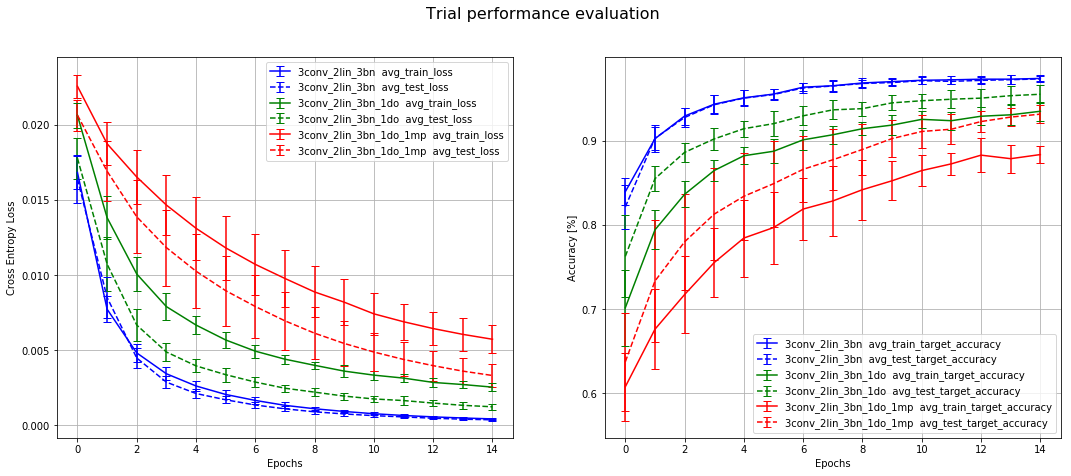

In [15]:
# Plot stuff for 3conv models
plot_this = [[('avg_train_loss','std_train_loss'),('avg_test_loss','std_test_loss')], \
             [('avg_train_target_accuracy','std_train_target_accuracy'),('avg_test_target_accuracy','std_test_target_accuracy')]]
axes, extrema = plot_performance(trial_summaries_digit[3:], plot_this, suptitle='Trial performance evaluation')
axes[0].set_ylabel('Cross Entropy Loss')
axes[1].set_ylabel('Accuracy [%]');